## Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import PIL
from PIL import Image
import os
import shutil
import splitfolders
import imagesize
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from datafunc import plot_example, min_max_dimensions, reshape
import cv2

## Data

In [4]:
datapath='../0. Project Data/Original Data'
org_data_dir = pathlib.Path(datapath).with_suffix('')
org_data_dir

WindowsPath('../0. Project Data/Original Data')

#### Loading Data

In [5]:
Blight = len(list(org_data_dir.glob('Blight/*.jpg')))
Common_Rust = len(list(org_data_dir.glob('Common_Rust/*.jpg')))
Gray_Leaf_Spot = len(list(org_data_dir.glob('Gray_Leaf_Spot/*.jpg')))
Healthy = len(list(org_data_dir.glob('Healthy/*.jpg')))
print('Blight images:', Blight)
print('Common Rust images:', Common_Rust)
print('Gray Leaf Spot images:', Gray_Leaf_Spot)
print('Healthy images:', Healthy)
print('Total images:', Blight + Common_Rust + Gray_Leaf_Spot + Healthy)

Blight images: 1146
Common Rust images: 1306
Gray Leaf Spot images: 574
Healthy images: 1162
Total images: 4188


#### Example Images

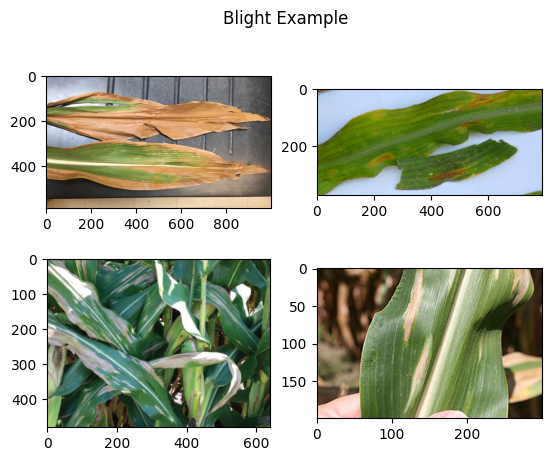

In [6]:
plot_example('Blight', org_data_dir)

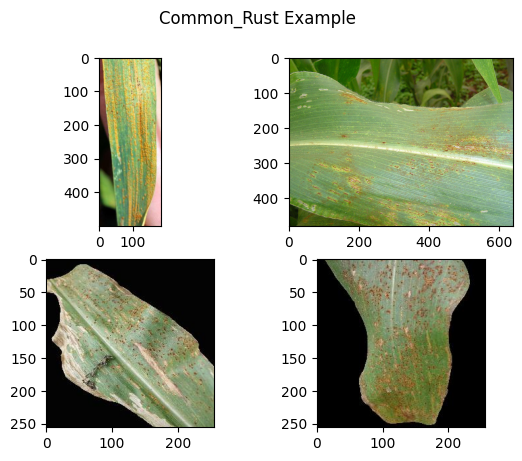

In [7]:
plot_example('Common_Rust', org_data_dir)

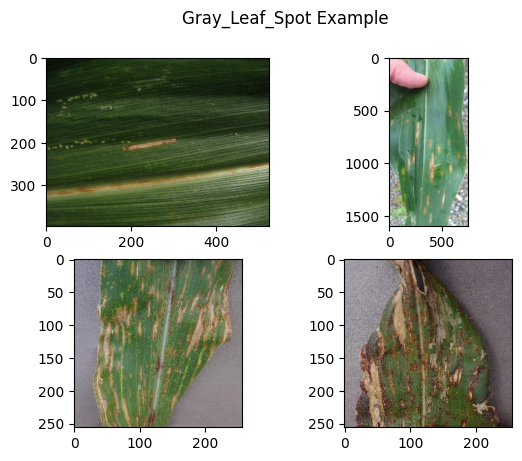

In [8]:
plot_example('Gray_Leaf_Spot', org_data_dir)

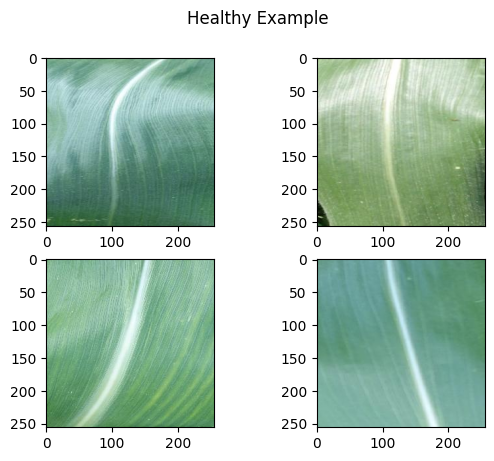

In [9]:
plot_example('Healthy', org_data_dir)

In [10]:
dims = min_max_dimensions(org_data_dir)
print( 'max dimensions', dims[0])
print( 'min dimensions', dims[1])

max dimensions (5184, 5184)
min dimensions (180, 116)


#### Image Resizing

We can see that input images have varying width and height dimensions. However, Covolutional Neural Networks require that input images all be of the same size in order for the matrix math to work correctly. There are several options to satisfy these requirements although some may have negative effects on training.

• **Cropping**

Cropping images means selecting a window size and centering it around the most important parts of the image. This introduces some new problems: deciding what part of the image is most important as well as the fact that certain border pixels are going to be removed resulting in potential loss of information. In addition, the wide variety of image dimensions (116 pixels to 5184 pixels) means a cropping widow for one image might not work as well for another image.
    
• **Stretching**

Stretching images means stretching or squashing the image to reach the desired dimensions. This results in less loss of information than cropping but features may be distorted. If the image is squashed, some information is loss due to the reduction in granularity. For both stretching and squashing, the relative spatial orientation of pixels becomes distorted which could interfere with the CNN's ability to isolate important features.
    
• **Zero-padding**

Zero-padding is our last solution and keeps original image size and aspect ratio. In order to convert each image to the same size, pixels of 0's are filled around the border of the image to make each resulting image the same size. A 2019 [study](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0263-7) showed that "zero-padding had no effect on the classification accuracy but considerably reduced the training time. The reason is that neighboring zero input units (pixels) will not activate their corresponding convolutional unit in the next layer. Therefore, the synaptic weights on outgoing links from input units do not need to be updated if they contain a zero value."


**Zero-padding** seems like the best solution

#### Zero-padding

In [22]:
dim = 256
reshaped_dir = '../0. Project Data/Reshaped Data/'
for directory in ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']:
    for index, image_dir in enumerate(org_data_dir.glob(directory+'/*.jpg')):
        image = cv2.imread(str(image_dir))
        width, height = imagesize.get(image_dir)
        aspect_ratio = width/ height
        save_path = reshaped_dir + directory + '/'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        filename = directory + str(index) + '.jpg'
        #print(width, height, aspect_ratio)
        if width == dim and height == dim:
            #print('width and height equal 256')
            cv2.imwrite(save_path+filename, image)
            #(save image to new location, no padding needed)
        elif max(width, height) > dim:
            if height >= width:
                desired_height = dim
                desired_width = int(dim * aspect_ratio)
                downscaled_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_AREA)
                #downscaled_image = cv2.resize(image, (0,256), interpolation=cv2.INTER_AREA)
            elif height < width:
                desired_width = dim
                desired_height = int(dim / aspect_ratio)
                downscaled_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_AREA)
                #downscaled_image = cv2.resize(image, (256,0), interpolation=cv2.INTER_AREA)
            cv2.imwrite(save_path+filename, downscaled_image)
            #print('max(width, height) is greater than 256, scale larger dim down to 256')
            #interarea interplation, https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image
            # ^ scale larger dim down to 256 + save
        elif max(width, height) < dim:
            if height >= width:
                desired_height = dim
                desired_width = int(dim * aspect_ratio)
                upscaled_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_CUBIC)
                #upscaled_image = cv2.resize(image, (0, 256), interpolation=cv2.INTER_CUBIC)
            elif height < width:
                desired_width = dim
                desired_height = int(dim / aspect_ratio) 
                upscaled_image = cv2.resize(image, (desired_width, desired_height), interpolation=cv2.INTER_CUBIC)
                #upscaled_image = cv2.resize(image, (256, 0), interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(save_path+filename, upscaled_image)
            #print('max(width, hieght) is less than 256, scale larger dim up to 256')
            #scale larger dim up to 256 +save 
        #break
    #break

max(width, hieght) is less than 256, scale larger dim up to 256
max(width, hieght) is less than 256, scale larger dim up to 256


In [24]:
reshape_path='../0. Project Data/Reshaped Data'
reshape_data_dir = pathlib.Path(reshape_path).with_suffix('')
reshape_data_dir

WindowsPath('../0. Project Data/Reshaped Data')

In [27]:
padded_dir = '../0. Project Data/Reshaped and zero-padded Data/'
for directory in ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']:
    for index, image_dir in enumerate(reshape_data_dir.glob(directory+'/*.jpg')):
        image = Image.open(image_dir)
        image = reshape(image, 256, 256, (0,0,0))
        image = image.convert('RGB')
        if not os.path.exists(padded_dir+directory):
            os.makedirs(padded_dir+directory)
        image.save(padded_dir + directory + '/'+ directory + str(index) + '.jpg')

#### Split into Train/Validation/Test

In [28]:
train_split_test_dir='../0. Project Data/Reshaped zero-padded and split data'
splitfolders.ratio(padded_dir, output=train_split_test_dir, seed=123, ratio=(.64, .16, .2)) # ratio of split are in order of train/val/test.